# Example 3: Use user defined processing graphs to pre-process a time series of Sentinel-1 images

## 1. Requirements

- Installation of SenSARP
- Installation of ESA's SNAP Toolbox version >8.0.3
    - Currently only SNAP version 8.0 can be downloaded from the ESA website (https://step.esa.int/main/download/snap-download/). To update SNAP to a version >8.0.3 please start the SNAP software. You will be asked if you want to search for update. After the updates are installed you need to restart SNAP to initialize the installed updates.
    - SNAP Toolbox need libgfortran for specific operations but currently libgfortran is not installed during the installation process of SNAP therefore you might use ```sudo apt-get install gfortran```

- Sentinel-1 SLC data
    - Instruction how to download Sentinel 1 data are given in Section 2

## 2. Download sample data from Sentinel Data Hub
### Option 1: Download data from Sentinel Data Hub manually or via python package sentinelsat

 <span style="color:red">Create Account (https://scihub.copernicus.eu/dhus/#/self-registration)</span>. (**<span style="color:red">Attention: Problem by using Copernicus Open Access Hub might be that older data is offline and need to be triggered first</span>)**. More information can be found at https://scihub.copernicus.eu/userguide/DataRestoration. Instruction to manually download data from Copernicus Open Access Hub can be found at https://blogs.fu-berlin.de/reseda/esa-scihub/. You can also try to download the data via python package sentinelsat

In [1]:
# connect to the API
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
user = 'user'
password = 'password'
# initialize settings
api = SentinelAPI(user, password)

Search for available data

In [2]:
# search by polygon (MNI test site coordinates), time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('coordinates_mni.geojson'))
products = api.query(footprint,
                     date=('20210704', '20210708'),
                     platformname='Sentinel-1',
                     producttype='GRD')
print('Following products will be downloaded')
print(api.to_dataframe(products).title.values)

print('These {} product need {} Gb of disk space'.format(len(products), api.get_products_size(products)))

INFO:sentinelsat.SentinelAPI:Found 2 products


Following products will be downloaded
['S1A_IW_GRDH_1SDV_20210707T051822_20210707T051847_038667_04901E_1B6B'
 'S1B_IW_GRDH_1SDV_20210706T052551_20210706T052616_027669_034D60_888E']
These 2 product need 3.28 Gb of disk space


Start download process (**<span style="color:red">Attention: might take a while and data will requries some free disk space</span>)**

In [3]:
# download all results from the search
# files will be downloaded to specified path
import os
path = os.path.expanduser('~/Desktop/data4')
try:
    os.makedirs(path)
except: FileExistsError
api.download_all(products, path)

INFO:sentinelsat.SentinelAPI:Will download 2 products using 4 workers


MD5 checksumming:   0%|          | 0.00/986M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/983M [00:00<?, ?B/s]

ResultTuple(downloaded={'ce796d52-4f70-48f0-87bf-d698ec372e9f': {'id': 'ce796d52-4f70-48f0-87bf-d698ec372e9f', 'title': 'S1B_IW_GRDH_1SDV_20210706T052551_20210706T052616_027669_034D60_888E', 'size': 986204913, 'md5': '56c6d22b25610fb30b01212d0b35101b', 'date': datetime.datetime(2021, 7, 6, 5, 25, 51, 753000), 'footprint': 'POLYGON((12.682894 47.832607,9.216668 48.236717,9.567789 49.733212,13.138339 49.327972,12.682894 47.832607))', 'url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('ce796d52-4f70-48f0-87bf-d698ec372e9f')/$value", 'Online': True, 'Creation Date': datetime.datetime(2021, 7, 6, 7, 26, 2, 888000), 'Ingestion Date': datetime.datetime(2021, 7, 6, 7, 24, 14, 101000), 'quicklook_url': "https://apihub.copernicus.eu/apihub/odata/v1/Products('ce796d52-4f70-48f0-87bf-d698ec372e9f')/Products('Quicklook')/$value", 'path': '/home/test/Desktop/data4/S1B_IW_GRDH_1SDV_20210706T052551_20210706T052616_027669_034D60_888E.zip', 'downloaded_bytes': 986204913}, 'caf75225-cb85-4410-

### Option 2: Download data from NASA Earth Data Search

You can search for Sentinel-1 data at https://search.asf.alaska.edu/. A NASA EOSDIS Earthdata Login account is required for downloading data and tools from ASF. Registering for an Earthdata Login account is free (https://urs.earthdata.nasa.gov/home). Instructions how to download data from ASF can be found at https://asf.alaska.edu/wp-content/uploads/2019/02/asf_datarecipe_bulk_download_from_vertex_python_script_v1.pdf.

## 3. Use user defined xml graph to process Sentinel-1 data (test case with Sentinel-1 GRD product)

Set paths for

- input_folder (path to stored Sentinel-1 SLC data (zip files) e.g. "~/Downloads")
- output_folder (path where processed data will be stored e.g. "~/output")
- gpt_loction (gpt is located in the bin folder of your SNAP installation)' 

In [5]:
input_folder = path
output_folder = path
gpt_location = os.path.expanduser('~/snap/bin/gpt')

Create config file with information about input, output and gpt location

In [6]:
import yaml

with open('sample_config_file.yaml') as stream:
   data = yaml.safe_load(stream)

data['input_folder'] = input_folder
data['output_folder'] = output_folder
data['gpt'] = gpt_location

with open('test_config_file.yaml', 'wb') as stream:
   yaml.safe_dump(data, stream, default_flow_style=False, 
                  explicit_start=True, allow_unicode=True, encoding='utf-8')

Expert user might create their own processing chain and use the functionally of SenSARP to automate the processing on scale 

1. Create a user defined xml graph via SNAP’s Graph Builder
    - information how to use SNAP’s Graph Builder can be found at the step forum (https://forum.step.esa.int/t/graph-builder/5403)
2. Modify user defined xml graph to be used by SenSARP
    - Needed modification
        - Placeholder for input image within xml graph need to be specified
        - Placeholder for output image within xml graph need to be specified
        - If subset operator is used within user defined xml graph a placeholder for subset extent need to be specified


Additional functionality of SenSARP that can be used with user defined xml graph

- Filter option (year, area of interest)
- default pre_process_step2 (co-registration of time series images)
- creation of netCDF4 stack containing all processed images and information about orbit direction, relative orbit, satellite name

Find and show xml parts that need to be changed

In [7]:
# Load xml graph
import xml.etree.ElementTree as ETree
user_xml_graph = '/home/test/Desktop/sar-pre-processing/sar_pre_processing/user_defined_graphs/example_of_expert_user.xml'
tree = ETree.parse(user_xml_graph)
root = tree.getroot()

# find Operators Read, Write and Subset
read = root.find("./node/[operator='Read']")
read2 = read.find("./parameters[@class='com.bc.ceres.binding.dom.XppDomElement']")
write = root.find("./node/[operator='Write']")
subset = root.find("./node/[operator='Subset']")

# Old Version of user defined xml graph
print(ETree.tostring(read, encoding='utf8').decode('utf8'))
print(ETree.tostring(write, encoding='utf8').decode('utf8'))
print(ETree.tostring(subset, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<node id="Read">
    <operator>Read</operator>
    <sources />
    <parameters class="com.bc.ceres.binding.dom.XppDomElement" />
  </node>
  
<?xml version='1.0' encoding='utf8'?>
<node id="Write">
    <operator>Write</operator>
    <sources>
      <sourceProduct refid="Subset" />
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <file>/home/wodan/target.dim</file>
      <formatName>BEAM-DIMAP</formatName>
    </parameters>
  </node>
  
<?xml version='1.0' encoding='utf8'?>
<node id="Subset">
    <operator>Subset</operator>
    <sources>
      <sourceProduct refid="Terrain-Correction" />
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <sourceBands />
      <region>0,0,0,0</region>
      <referenceBand />
      <geoRegion />
      <subSamplingX>1</subSamplingX>
      <subSamplingY>1</subSamplingY>
      <fullSwath>false</fullSwath>
      <tiePointGridNames />
      <copyMetadata

Modify xml parts so the xml-graph can be used by SenSARP

In [8]:
#Apply changes to user defined xml graph
ETree.SubElement(read2, "file").text = "$input"
for output in write.iter('file'):
    output_new = '$output'
    output.text = output_new
for area in subset.iter('geoRegion'):
    area_new = '$area'
    area.text = area_new

tree.write('/home/test/Desktop/sar-pre-processing/sar_pre_processing/user_defined_graphs/example_of_expert_user_modi.xml')

# print modified version of operators Read, Write and Subset
print(ETree.tostring(read, encoding='utf8').decode('utf8'))
print(ETree.tostring(write, encoding='utf8').decode('utf8'))
print(ETree.tostring(subset, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<node id="Read">
    <operator>Read</operator>
    <sources />
    <parameters class="com.bc.ceres.binding.dom.XppDomElement"><file>$input</file></parameters>
  </node>
  
<?xml version='1.0' encoding='utf8'?>
<node id="Write">
    <operator>Write</operator>
    <sources>
      <sourceProduct refid="Subset" />
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <file>$output</file>
      <formatName>BEAM-DIMAP</formatName>
    </parameters>
  </node>
  
<?xml version='1.0' encoding='utf8'?>
<node id="Subset">
    <operator>Subset</operator>
    <sources>
      <sourceProduct refid="Terrain-Correction" />
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <sourceBands />
      <region>0,0,0,0</region>
      <referenceBand />
      <geoRegion>$area</geoRegion>
      <subSamplingX>1</subSamplingX>
      <subSamplingY>1</subSamplingY>
      <fullSwath>false</fullSwath>
      <tiePointGr

Set additional config options

In [9]:
with open('test_config_file.yaml') as stream:
   data = yaml.safe_load(stream)

# Filter option
## Filter via year of interest
data['year'] = '2021'

## Define region of interest
data['region']['lr']['lat'] = 48.2 # lower right latitude
data['region']['lr']['lon'] = 11.9 # lower right longitude
data['region']['ul']['lat'] = 48.4 # upper left latitude
data['region']['ul']['lon'] = 11.6 # upper left longitude
data['region']['subset'] = 'yes'

## Set options to use user defined xml graph
data['use_user_defined_graphs'] = 'yes'
data['xml_graph_path'] = '/media/tweiss/Daten/NDVI'
data['pre_process_step1'] = 'ndvi.xml'

with open('test_config_file.yaml', 'wb') as stream:
   yaml.safe_dump(data, stream, default_flow_style=False,
                  explicit_start=True, allow_unicode=True, encoding='utf-8')

Start pre-processing steps

In [23]:
from sar_pre_processing.sar_pre_processor import *
import warnings
warnings.filterwarnings("ignore")

processing = SARPreProcessor(config='test_config_file.yaml')

In [94]:
import os
from fnmatch import fnmatch

input_folder = '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new'
pattern = '*B11.tif'
pattern2 = '*B8.tif'
file_list = []
file_list2 = []
for path, subdirs, files in os.walk(input_folder):
    for name in files:
        if fnmatch(name, pattern):
            file_list.append(os.path.join(path, name))
        if fnmatch(name, pattern2):
            file_list.append(os.path.join(path, name))            
            
            
            
#pattern = '*B11.tif'
#for path, subdirs, files in os.walk(input_folder):
#    for name in files:
#        if fnmatch(name, pattern):
#            file_list2.append(os.path.join(path, name))
            
            
print(len(file_list))
#print(len(file_list2))
filelist = [[],file_list]

54


In [95]:
file_list

['/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU_atmcorr/COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU_atmcorr/COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU.B8.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180422T102031_20180422T102115_T32UPU_atmcorr/COPERNICUS_S2_20180422T102031_20180422T102115_T32UPU.B8.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180422T102031_20180422T102115_T32UPU_atmcorr/COPERNICUS_S2_20180422T102031_20180422T102115_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180701T102021_20180701T102404_T32UPU_atmcorr/COPERNICUS_S2_20180701T102021_20180701T102404_T32UPU.B8.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180701T102021_20180701T10

In [96]:
xxx = file_list.sort()

In [97]:
from sar_pre_processing.sar_pre_processor import *
import warnings
warnings.filterwarnings("ignore")
#### Attention when using ndwi1.xml or ndwi2.xml grid size of image B11 and B12 are different to B3!!!
processing = SARPreProcessor(config='test_config_file.yaml')
processing.config.use_user_defined_graphs = 'yes'
processing.name_addition_step1 = '_NDWI18'
processing.config.output_folder = '/media/tweiss/Daten/NDWI1/sentinel_2_2018_2'
processing.config.input_folder = '/media/tweiss/Daten/NDWI1/sentinel_2_2018_2'
processing.config.pre_process_step1 = '/media/tweiss/Daten/NDWI/ndwi.xml'
processing.config.pre_process_step1_border = '/media/tweiss/Daten/NDWI1/ndwi1.xml'
processing.config.output_folder_step1 = '/media/tweiss/Daten/NDWI1/sentinel_2_2018_2/step1_2'
#processing.file_list
processing.config.xml_graph_path = '/media/tweiss/Daten/NDWI'
processing.config.pre_process_step1 = 'ndvi.xml'
input_folder = '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new'
processing.config.use_user_defined_graphs = 'no'
processing.config.region.subset == 'no'
processing.config.gpt = '/home/tweiss/snap/bin/gpt'
#pattern = '*B12.tif'
processing.file_list = filelist

In [98]:
processing.config.__dict__

{'gpt': '/home/tweiss/snap/bin/gpt',
 'input_folder': '/media/tweiss/Daten/NDWI1/sentinel_2_2018_2',
 'output_folder': '/media/tweiss/Daten/NDWI1/sentinel_2_2018_2',
 'region': <sar_pre_processing.attribute_dict.AttributeDict at 0x7f0dfa14bad0>,
 'single_file': 'no',
 'speckle_filter': <sar_pre_processing.attribute_dict.AttributeDict at 0x7f0df9bd4950>,
 'use_user_defined_graphs': 'no',
 'year': '2021',
 'output_folder_step1': '/media/tweiss/Daten/NDWI1/sentinel_2_2018_2/step1_2',
 'output_folder_step2': '/path/to/data/step2',
 'output_folder_step3': '/path/to/data/step3',
 'pre_process_step1': 'ndvi.xml',
 'pre_process_step1_border': '/media/tweiss/Daten/NDWI1/ndwi1.xml',
 'pre_process_step2': '/home/tweiss/.cache/Python-Eggs/multiply_sar_pre_processing-0.1-py3.7.egg-tmp/sar_pre_processing/default_graphs/pre_process_step2.xml',
 'pre_process_step3': '/home/tweiss/.cache/Python-Eggs/multiply_sar_pre_processing-0.1-py3.7.egg-tmp/sar_pre_processing/default_graphs/pre_process_step3.xml',


In [99]:
#file_list2 = processing.file_list[1][1::2]

#print(file_list2)
print(processing.file_list[1][::2][2])
print(processing.file_list[1][1::2][2])

/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU_atmcorr/COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU.B11.tif
/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU_atmcorr/COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU.B8.tif


In [100]:
processing.file_list[1][0]

'/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180124T101309_20180124T101352_T32UPU_atmcorr/COPERNICUS_S2_20180124T101309_20180124T101352_T32UPU.B11.tif'

In [101]:
processing.file_list[1][::2]

['/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180124T101309_20180124T101352_T32UPU_atmcorr/COPERNICUS_S2_20180124T101309_20180124T101352_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180213T101119_20180213T101559_T32UPU_atmcorr/COPERNICUS_S2_20180213T101119_20180213T101559_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU_atmcorr/COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU_atmcorr/COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180419T101031_20180419T101457_T32UPU_atmcorr/COPERNICUS_S2_20180419T101031_20180419T101457_T32UPU.B11.tif',
 '/media/nas_data/Tom/Data_BKP/Data/Sentinel/S2_2018_new/COPERNICUS_S2_20180422T102031_20180422

In [102]:
processing.pre_process_step1()

INFO:root:area of interest specified
INFO:root:normalisation angle not specified, default value of 35 is used for processing
INFO:ComponentProgress:0
INFO:ComponentProgress:0
INFO:root:Process COPERNICUS_S2_20180124T101309_20180124T101352_T32UPU.B11.tif with SNAP.
INFO:root:0
INFO:ComponentProgress:1
INFO:ComponentProgress:1
INFO:root:Process COPERNICUS_S2_20180213T101119_20180213T101559_T32UPU.B11.tif with SNAP.
INFO:root:0
INFO:ComponentProgress:3
INFO:ComponentProgress:3
INFO:root:Process COPERNICUS_S2_20180228T101021_20180228T101021_T32UPU.B11.tif with SNAP.
INFO:root:0
INFO:ComponentProgress:5
INFO:ComponentProgress:5
INFO:root:Process COPERNICUS_S2_20180407T102019_20180407T102020_T32UPU.B11.tif with SNAP.
INFO:root:0
INFO:ComponentProgress:7
INFO:ComponentProgress:7
INFO:root:Process COPERNICUS_S2_20180419T101031_20180419T101457_T32UPU.B11.tif with SNAP.
INFO:root:0
INFO:ComponentProgress:9
INFO:ComponentProgress:9
INFO:root:Process COPERNICUS_S2_20180422T102031_20180422T102115_T

In [10]:
from sar_pre_processing.sar_pre_processor import *
import warnings
warnings.filterwarnings("ignore")

processing = SARPreProcessor(config='test_config_file.yaml')
processing.create_processing_file_list()
print('start step 1')
processing.pre_process_step1()
print('start step 2')
processing.pre_process_step2()
print('start step 3')
processing.pre_process_step3()
print('start add netcdf information')
processing.add_netcdf_information()
print('start create netcdf stack')
processing.create_netcdf_stack()

INFO:root:Found files within input folder: 2
INFO:root:Number of found files for year 2021: 2
INFO:root:area of interest not specified
INFO:root:Number of found files that were double processed: 0.0
INFO:root:Number of found files with border issues: 0
INFO:root:area of interest specified
INFO:root:normalisation angle not specified, default value of 35 is used for processing
INFO:ComponentProgress:0
INFO:ComponentProgress:0
INFO:root:Process S1A_IW_GRDH_1SDV_20210707T051822_20210707T051847_038667_04901E_1B6B.zip with SNAP.


start step 1


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/07


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: 35 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:A AND producttype:AUX_RESORB AND beginposition:[2021-06-01T00:00:000Z TO 2021-06-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2021/07


version = 3.31
...10%....21%....33%....44%...54%....65%....77%....88%. done.


INFO:root:0
INFO:ComponentProgress:50
INFO:ComponentProgress:50
INFO:root:Process S1B_IW_GRDH_1SDV_20210706T052551_20210706T052616_027669_034D60_888E.zip with SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/07


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: 36 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-07-01T00:00:000Z TO 2021-07-31T24:00:000Z]
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_RESORB AND beginposition:[2021-06-01T00:00:000Z TO 2021-06-31T24:00:000Z]
OpenSearch: 0 total results on 1 pages.


Orbit files may be downloaded from https://scihub.copernicus.eu/gnss/odata/v1/
and placed in /home/test/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1B/2021/07


version = 3.31
....11%....23%....34%....46%....57%....69%....80%.... done.


INFO:root:0
INFO:ComponentProgress:0
INFO:ComponentProgress:0
INFO:root:Scene 1 of 2
INFO:root:Process S1A_IW_GRDH_1SDV_20210707T051822_20210707T051847_038667_04901E_1B6B_GC_RC_No_Su.dim with SNAP.


start step 2


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start


....

14638 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
14676 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
14676 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


11%....22%...32%....43%...53%....64%....75%...85%..

-- org.jblas INFO Deleting /tmp/jblas4819000381521070295/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas4819000381521070295/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas4819000381521070295/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas4819000381521070295/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas4819000381521070295
INFO:root:0
INFO:root:2021-08-29 20:28:51.715338
INFO:ComponentProgress:50
INFO:ComponentProgress:50
INFO:root:Scene 2 of 2
INFO:root:Process S1B_IW_GRDH_1SDV_20210706T052551_20210706T052616_027669_034D60_888E_GC_RC_No_Su.dim with SNAP.


 done.


INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.


Executing processing graph


INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.core.datamodel.Product: raster width 3341 not equal to 3340
INFO: org.esa.snap.core.datamodel.Product: raster width 3341 not equal to 3340


....

14858 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/test/.snap/auxdata/netcdf_natives/8.0.5/amd64', libname='netcdf').
14895 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
14895 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0


11%....22%...32%....43%...53%....64%....75%...85%.. done.


-- org.jblas INFO Deleting /tmp/jblas4294428937644417987/libjblas.so
-- org.jblas INFO Deleting /tmp/jblas4294428937644417987/libgfortran-4.so
-- org.jblas INFO Deleting /tmp/jblas4294428937644417987/libjblas_arch_flavor.so
-- org.jblas INFO Deleting /tmp/jblas4294428937644417987/libquadmath-0.so
-- org.jblas INFO Deleting /tmp/jblas4294428937644417987
INFO:root:0
INFO:root:2021-08-29 20:29:42.545034
INFO:root:combination of default multi temporal speckle filter and user defined graphs is not supported yet


start step 3
start add netcdf information


INFO:root:Number of scenes found for processing: 2


start create netcdf stack

Scene 1 of 2
/home/test/Desktop/data4/step2/S1B_IW_GRDH_1SDV_20210706T052551_20210706T052616_027669_034D60_888E_GC_RC_No_Su_Co.nc

Scene 2 of 2
/home/test/Desktop/data4/step2/S1A_IW_GRDH_1SDV_20210707T051822_20210707T051847_038667_04901E_1B6B_GC_RC_No_Su_Co.nc


## 4. View processed data

Load netcdf file with processed data

In [11]:
import os
print(os.getcwd())
print(output_folder)

/home/test/Desktop/sar-pre-processing/docs/notebooks
/home/test/Desktop/data4


In [12]:
from netCDF4 import Dataset
import numpy as np

my_example_nc_file = os.path.join(output_folder, 'data4.nc')
data = Dataset(my_example_nc_file, mode='r') 

View information about dataset

In [13]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(2227), lon(3341), time(2)
    variables(dimensions): float32 time(time), float32 orbitdirection(time), float32 relorbit(time), float32 satellite(time), float32 lat(lat), float32 lon(lon), float32 Sigma0_VH(time, lat, lon), float32 Sigma0_VV(time, lat, lon)
    groups: 

Read data from netcdf file

In [14]:
data.variables['orbitdirection'][:]
data.variables['time'][:]
lons = data.variables['lon'][:]
lats = data.variables['lat'][:]
data.variables.keys()

dict_keys(['time', 'orbitdirection', 'relorbit', 'satellite', 'lat', 'lon', 'Sigma0_VH', 'Sigma0_VV'])

In [15]:
vv = data.variables['Sigma0_VV'][:]


Close netcdf file

In [16]:
data.close()

Plot vv polorized data

interactive(children=(IntSlider(value=0, description='x', max=1), Output()), _dom_classes=('widget-interact',)…

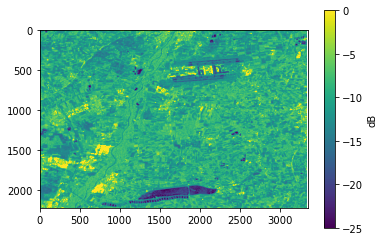

In [17]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    # Problem: border pixel might be zero or negative
    # pixel eqal or smaller than zero are set to nan
    array = np.copy(vv[x])
    array[array <= 0] = np.nan
    # plot backscatter data in dB scale
    plt.imshow(10*np.log10(array))
    cbar = plt.colorbar()
    cbar.set_label('dB')
    plt.clim(-25, 0)

interactive_plot = interactive(f, x=(0,len(vv)-1))
interactive_plot